In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
# from tools.GRU_AR_v6 import AR_RNN_GRU as AR_RNN
from tools.LSTM_AR_v1 import AR_RNN_LSTM as AR_RNN
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-12 19:05:49.857105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:05:49.857318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:05:49.889147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:05:49.889383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-12 19:05:49.889664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_053'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_053
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

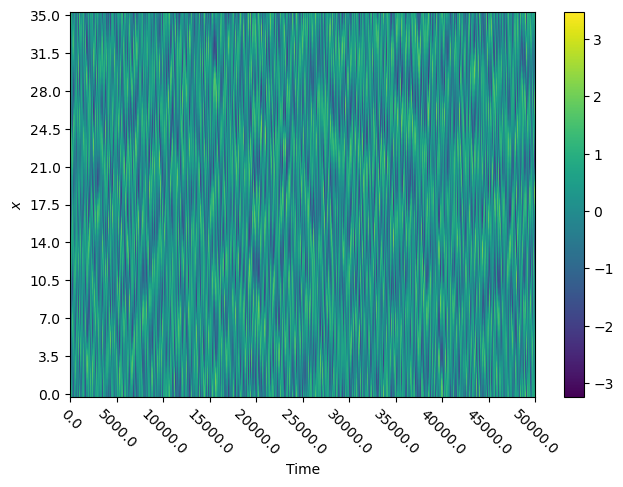

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50, 70])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [5e-5],
        [5e-5],
        [1e-5],
        [1e-6],
        [5e-7],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [30],
        [30],
        [30],
        [50],
        [50],
    ] # parameter for early stopping
    min_delta = 1e-5  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 32
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_rnn_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
76/76 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.8219e-04 - NMSE: 0.0034 - covmat_fro_loss: 2.3716e-04 - global_gradnorm: 0.3895 - tot_time: 0h 0m 25.1s

Epoch 1: val_NMSE improved from inf to 0.00304, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/check

76/76 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.8708e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0822e-04 - global_gradnorm: 0.3089 - tot_time: 0h 1m 55.1s

Epoch 11: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 115ms/step - loss: 0.0029 - mse: 2.8708e-04 - NMSE: 0.0026 - covmat_fro_loss: 2.0848e-04 - global_gradnorm: 0.3092 - val_loss: 0.0032 - val_mse: 3.2748e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
76/76 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.0413e-04 - NMSE: 0.0027 - covmat_fro_loss: 2.1332e-04 - global_gradnorm: 0.3418 - tot_time: 0h 2m 4.0s

Epoch 12: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/che

Epoch 23/1000
76/76 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.4657e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9361e-04 - global_gradnorm: 0.2571 - tot_time: 0h 3m 43.6s

Epoch 23: val_NMSE did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 120ms/step - loss: 0.0026 - mse: 2.4657e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9350e-04 - global_gradnorm: 0.2568 - val_loss: 0.0029 - val_mse: 2.8370e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
76/76 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.6956e-04 - NMSE: 0.0024 - covmat_fro_loss: 2.0199e-04 - global_gradnorm: 0.3062 - tot_time: 0h 3m 52.7s

Epoch 24: val_NMSE did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 35/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.4359e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9274e-04 - global_gradnorm: 0.2558 - tot_time: 0h 5m 32.5s

Epoch 35: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 119ms/step - loss: 0.0025 - mse: 2.4359e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9266e-04 - global_gradnorm: 0.2558 - val_loss: 0.0027 - val_mse: 2.6375e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.4268e-04 - NMSE: 0.0022 - covmat_fro_loss: 1.9235e-04 - global_gradnorm: 0.2532 - tot_time: 0h 5m 41.6s

Epoch 36: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 47/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.2734e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8658e-04 - global_gradnorm: 0.2403 - tot_time: 0h 7m 19.8s

Epoch 47: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 119ms/step - loss: 0.0024 - mse: 2.2734e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8673e-04 - global_gradnorm: 0.2406 - val_loss: 0.0029 - val_mse: 2.8146e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
76/76 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.3541e-04 - NMSE: 0.0021 - covmat_fro_loss: 1.8996e-04 - global_gradnorm: 0.2519 - tot_time: 0h 7m 28.8s

Epoch 48: val_NMSE did not improve from 0.00220
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn

Epoch 59/1000
76/76 [==============================] - ETA: 0s - loss: 0.0024 - mse: 2.2118e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8437e-04 - global_gradnorm: 0.2443 - tot_time: 0h 9m 7.4s

Epoch 59: val_NMSE improved from 0.00215 to 0.00215, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 10s 127ms/step - loss: 0.0024 - mse: 2.2118e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8439e-04 - global_gradnorm: 0.2438 - val_loss: 0.0025 - val_mse: 2.3859e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.1825e-04 - NMSE: 0.0020 - covmat_fro_loss: 1.8315e-04 - global_gradnorm: 0.2368 - tot_time: 0h 9m 17.0s

Epoch 60:

Epoch 71/1000
76/76 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.1600e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.8251e-04 - global_gradnorm: 0.2334 - tot_time: 0h 10m 57.5s

Epoch 71: val_NMSE did not improve from 0.00208
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 119ms/step - loss: 0.0023 - mse: 2.1600e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.8263e-04 - global_gradnorm: 0.2329 - val_loss: 0.0025 - val_mse: 2.3814e-04 - val_NMSE: 0.0021 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 72/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.0846e-04 - NMSE: 0.0019 - covmat_fro_loss: 1.7946e-04 - global_gradnorm: 0.2183 - tot_time: 0h 11m 6.5s

Epoch 72: val_NMSE did not improve from 0.00208
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rn

Epoch 83/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.0432e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7789e-04 - global_gradnorm: 0.2229 - tot_time: 0h 12m 46.7s

Epoch 83: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 118ms/step - loss: 0.0022 - mse: 2.0432e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7780e-04 - global_gradnorm: 0.2235 - val_loss: 0.0026 - val_mse: 2.5012e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 84/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 1.9966e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7613e-04 - global_gradnorm: 0.2074 - tot_time: 0h 12m 55.6s

Epoch 84: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.9171e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7278e-04 - global_gradnorm: 0.2044 - tot_time: 0h 14m 34.2s

Epoch 95: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 119ms/step - loss: 0.0021 - mse: 1.9171e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7269e-04 - global_gradnorm: 0.2043 - val_loss: 0.0023 - val_mse: 2.1425e-04 - val_NMSE: 0.0019 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 96/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 1.9649e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7459e-04 - global_gradnorm: 0.2145 - tot_time: 0h 14m 43.2s

Epoch 96: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/

Epoch 107/1000
76/76 [==============================] - ETA: 0s - loss: 0.0021 - mse: 1.9076e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7235e-04 - global_gradnorm: 0.2056 - tot_time: 0h 16m 22.3s

Epoch 107: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 9s 119ms/step - loss: 0.0021 - mse: 1.9076e-04 - NMSE: 0.0017 - covmat_fro_loss: 1.7241e-04 - global_gradnorm: 0.2061 - val_loss: 0.0024 - val_mse: 2.2683e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 108/1000
76/76 [==============================] - ETA: 0s - loss: 0.0022 - mse: 1.9851e-04 - NMSE: 0.0018 - covmat_fro_loss: 1.7553e-04 - global_gradnorm: 0.2149 - tot_time: 0h 16m 31.2s

Epoch 108: val_NMSE did not improve from 0.00192
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

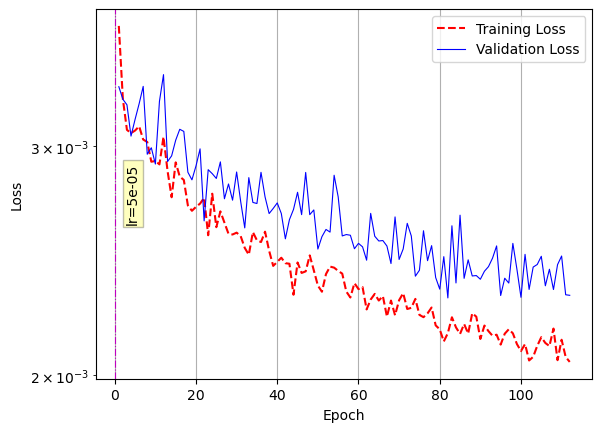

<Figure size 640x480 with 0 Axes>

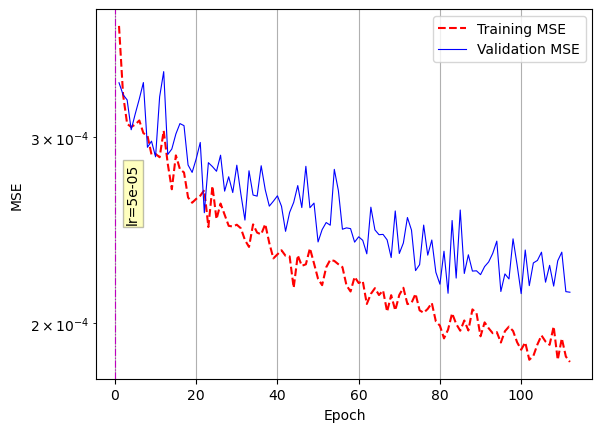

<Figure size 640x480 with 0 Axes>

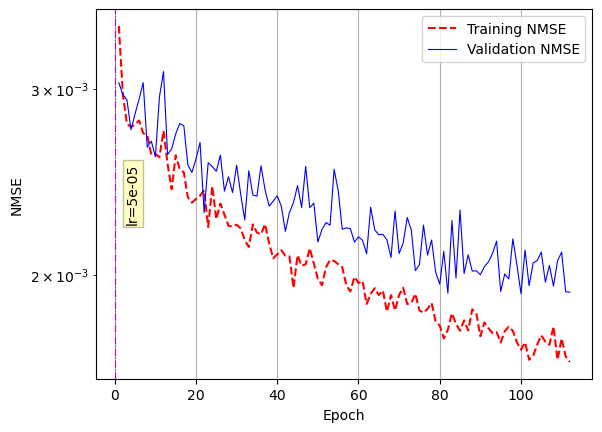

<Figure size 640x480 with 0 Axes>

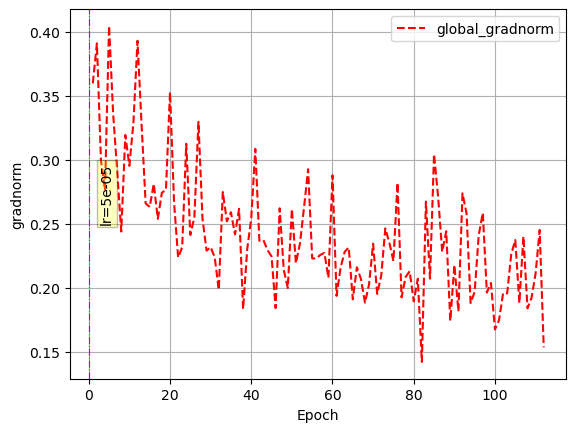



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.32387020587921145


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0057 - mse: 6.5636e-04 - NMSE: 0.0059 - covmat_fro_loss: 5.5353e-04 - global_gradnorm: 0.3239 - tot_time: 0h 0m 41.0s

Epoch 1: val_NMSE improved from inf to 0.00460, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/

Epoch 12/1000
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.8006e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.8152e-04 - global_gradnorm: 0.3239 - tot_time: 0h 2m 38.1s

Epoch 12: val_NMSE did not improve from 0.00419
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 148ms/step - loss: 0.0043 - mse: 4.8006e-04 - NMSE: 0.0043 - covmat_fro_loss: 4.8160e-04 - global_gradnorm: 0.3239 - val_loss: 0.0045 - val_mse: 5.0654e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.8402e-04 - NMSE: 0.0044 - covmat_fro_loss: 4.8248e-04 - global_gradnorm: 0.3239 - tot_time: 0h 2m 48.5s

Epoch 13: val_NMSE did not improve from 0.00419
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

Epoch 24/1000
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.5477e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.7047e-04 - global_gradnorm: 0.3239 - tot_time: 0h 4m 43.4s

Epoch 24: val_NMSE did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 147ms/step - loss: 0.0041 - mse: 4.5477e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.7053e-04 - global_gradnorm: 0.3239 - val_loss: 0.0043 - val_mse: 4.7819e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
71/71 [==============================] - ETA: 0s - loss: 0.0039 - mse: 4.3408e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.5978e-04 - global_gradnorm: 0.3239 - tot_time: 0h 4m 53.8s

Epoch 25: val_NMSE did not improve from 0.00412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

Epoch 36/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.9656e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.4110e-04 - global_gradnorm: 0.3239 - tot_time: 0h 6m 49.0s

Epoch 36: val_NMSE did not improve from 0.00390
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 151ms/step - loss: 0.0036 - mse: 3.9656e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.4131e-04 - global_gradnorm: 0.3239 - val_loss: 0.0039 - val_mse: 4.3412e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 4.0142e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.4214e-04 - global_gradnorm: 0.3239 - tot_time: 0h 6m 59.6s

Epoch 37: val_NMSE did not improve from 0.00390
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_r

Epoch 48/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.8113e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.3243e-04 - global_gradnorm: 0.3239 - tot_time: 0h 8m 55.6s

Epoch 48: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 148ms/step - loss: 0.0035 - mse: 3.8113e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.3309e-04 - global_gradnorm: 0.3239 - val_loss: 0.0039 - val_mse: 4.3426e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.9819e-04 - NMSE: 0.0036 - covmat_fro_loss: 4.4292e-04 - global_gradnorm: 0.3239 - tot_time: 0h 9m 5.9s

Epoch 49: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rn

Epoch 60/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.7660e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.3148e-04 - global_gradnorm: 0.3235 - tot_time: 0h 11m 0.9s

Epoch 60: val_NMSE did not improve from 0.00356
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 146ms/step - loss: 0.0035 - mse: 3.7660e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.3121e-04 - global_gradnorm: 0.3233 - val_loss: 0.0038 - val_mse: 4.1351e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
71/71 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.7674e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.3164e-04 - global_gradnorm: 0.3235 - tot_time: 0h 11m 11.3s

Epoch 61: val_NMSE did not improve from 0.00356
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

71/71 [==============================] - ETA: 0s - loss: 0.0033 - mse: 3.5765e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.2124e-04 - global_gradnorm: 0.3239 - tot_time: 0h 13m 6.8s

Epoch 72: val_NMSE did not improve from 0.00356
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 145ms/step - loss: 0.0033 - mse: 3.5765e-04 - NMSE: 0.0032 - covmat_fro_loss: 4.2140e-04 - global_gradnorm: 0.3239 - val_loss: 0.0040 - val_mse: 4.3573e-04 - val_NMSE: 0.0039 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 73/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.4423e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.1340e-04 - global_gradnorm: 0.3212 - tot_time: 0h 13m 17.2s

Epoch 73: val_NMSE did not improve from 0.00356
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027

Epoch 84/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.3709e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0914e-04 - global_gradnorm: 0.3212 - tot_time: 0h 15m 12.7s

Epoch 84: val_NMSE did not improve from 0.00340
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 148ms/step - loss: 0.0032 - mse: 3.3709e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0908e-04 - global_gradnorm: 0.3212 - val_loss: 0.0039 - val_mse: 4.2569e-04 - val_NMSE: 0.0038 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 85/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.4255e-04 - NMSE: 0.0031 - covmat_fro_loss: 4.1166e-04 - global_gradnorm: 0.3230 - tot_time: 0h 15m 23.2s

Epoch 85: val_NMSE did not improve from 0.00340
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.2381e-04 - NMSE: 0.0029 - covmat_fro_loss: 4.0222e-04 - global_gradnorm: 0.3204 - tot_time: 0h 17m 18.0s

Epoch 96: val_NMSE did not improve from 0.00340
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 146ms/step - loss: 0.0031 - mse: 3.2381e-04 - NMSE: 0.0029 - covmat_fro_loss: 4.0216e-04 - global_gradnorm: 0.3204 - val_loss: 0.0035 - val_mse: 3.7939e-04 - val_NMSE: 0.0034 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 97/1000
71/71 [==============================] - ETA: 0s - loss: 0.0031 - mse: 3.2839e-04 - NMSE: 0.0030 - covmat_fro_loss: 4.0441e-04 - global_gradnorm: 0.3214 - tot_time: 0h 17m 28.4s

Epoch 97: val_NMSE did not improve from 0.00340
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_02

Epoch 108/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.1411e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9481e-04 - global_gradnorm: 0.3200 - tot_time: 0h 19m 23.7s

Epoch 108: val_NMSE did not improve from 0.00323
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 148ms/step - loss: 0.0030 - mse: 3.1411e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9513e-04 - global_gradnorm: 0.3201 - val_loss: 0.0034 - val_mse: 3.6784e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 109/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.1808e-04 - NMSE: 0.0029 - covmat_fro_loss: 3.9824e-04 - global_gradnorm: 0.3171 - tot_time: 0h 19m 34.2s

Epoch 109: val_NMSE did not improve from 0.00323
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 120/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.1574e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9744e-04 - global_gradnorm: 0.3203 - tot_time: 0h 21m 29.9s

Epoch 120: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 146ms/step - loss: 0.0030 - mse: 3.1574e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9769e-04 - global_gradnorm: 0.3204 - val_loss: 0.0038 - val_mse: 4.1453e-04 - val_NMSE: 0.0037 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 121/1000
71/71 [==============================] - ETA: 0s - loss: 0.0030 - mse: 3.1208e-04 - NMSE: 0.0028 - covmat_fro_loss: 3.9524e-04 - global_gradnorm: 0.3212 - tot_time: 0h 21m 40.3s

Epoch 121: val_NMSE did not improve from 0.00320
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 132/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.8451e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7816e-04 - global_gradnorm: 0.3130 - tot_time: 0h 23m 35.1s

Epoch 132: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 144ms/step - loss: 0.0028 - mse: 2.8451e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7817e-04 - global_gradnorm: 0.3131 - val_loss: 0.0037 - val_mse: 4.0109e-04 - val_NMSE: 0.0036 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 133/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.9359e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.8326e-04 - global_gradnorm: 0.3124 - tot_time: 0h 23m 45.5s

Epoch 133: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 2.9548e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8511e-04 - global_gradnorm: 0.3141 - tot_time: 0h 25m 40.4s

Epoch 144: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 145ms/step - loss: 0.0029 - mse: 2.9548e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.8452e-04 - global_gradnorm: 0.3133 - val_loss: 0.0034 - val_mse: 3.6139e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 145/1000
71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.8567e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.7724e-04 - global_gradnorm: 0.3077 - tot_time: 0h 25m 50.7s

Epoch 145: val_NMSE did not improve from 0.00313
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 156/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7672e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7271e-04 - global_gradnorm: 0.3084 - tot_time: 0h 27m 46.2s

Epoch 156: val_NMSE did not improve from 0.00307
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 148ms/step - loss: 0.0027 - mse: 2.7672e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7349e-04 - global_gradnorm: 0.3086 - val_loss: 0.0034 - val_mse: 3.5515e-04 - val_NMSE: 0.0032 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 157/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7439e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7092e-04 - global_gradnorm: 0.3088 - tot_time: 0h 27m 56.5s

Epoch 157: val_NMSE did not improve from 0.00307
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0028 - mse: 2.8148e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7600e-04 - global_gradnorm: 0.3109 - tot_time: 0h 29m 51.4s

Epoch 168: val_NMSE improved from 0.00307 to 0.00307, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 153ms/step - loss: 0.0028 - mse: 2.8148e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7580e-04 - global_gradnorm: 0.3111 - val_loss: 0.0033 - val_mse: 3.4096e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 169/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7099e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6897e-04 - global_gradnorm: 0.3009 - tot_time: 0h 30m 2.1s

Epoch 169: val_NM

Epoch 180/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.6651e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6612e-04 - global_gradnorm: 0.2929 - tot_time: 0h 31m 56.9s

Epoch 180: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 10s 145ms/step - loss: 0.0027 - mse: 2.6651e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6585e-04 - global_gradnorm: 0.2922 - val_loss: 0.0032 - val_mse: 3.3777e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 181/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.7591e-04 - NMSE: 0.0025 - covmat_fro_loss: 3.7274e-04 - global_gradnorm: 0.3049 - tot_time: 0h 32m 7.5s

Epoch 181: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

71/71 [==============================] - ETA: 0s - loss: 0.0026 - mse: 2.6184e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6349e-04 - global_gradnorm: 0.2940 - tot_time: 0h 34m 2.8s

Epoch 192: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 11s 148ms/step - loss: 0.0026 - mse: 2.6184e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6333e-04 - global_gradnorm: 0.2942 - val_loss: 0.0035 - val_mse: 3.6663e-04 - val_NMSE: 0.0033 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 193/1000
71/71 [==============================] - ETA: 0s - loss: 0.0027 - mse: 2.6885e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.6765e-04 - global_gradnorm: 0.2999 - tot_time: 0h 34m 13.2s

Epoch 193: val_NMSE did not improve from 0.00287
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

<Figure size 640x480 with 0 Axes>

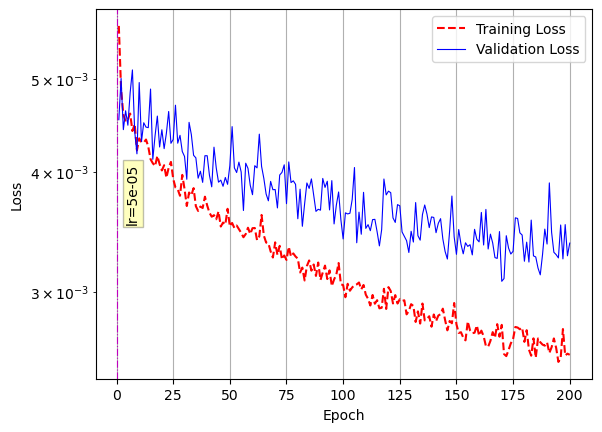

<Figure size 640x480 with 0 Axes>

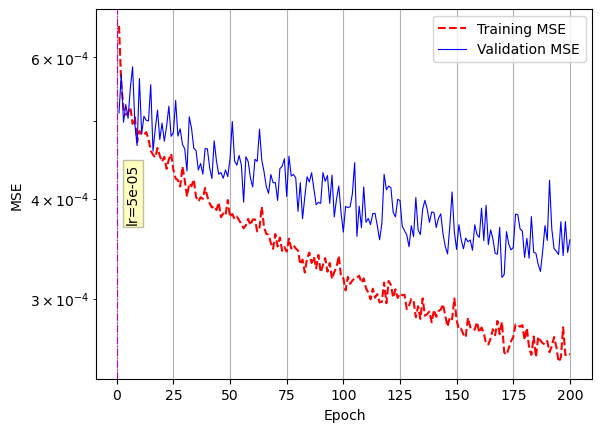

<Figure size 640x480 with 0 Axes>

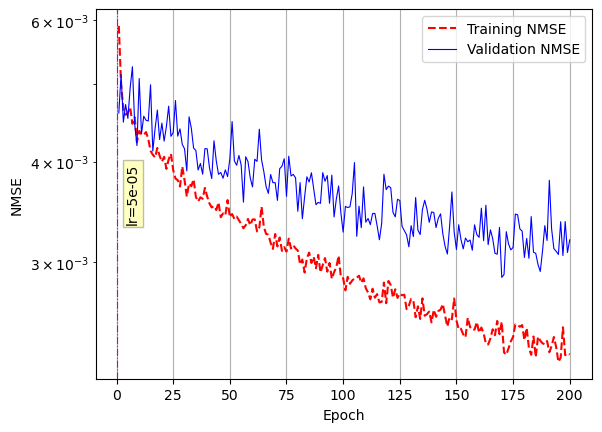

<Figure size 640x480 with 0 Axes>

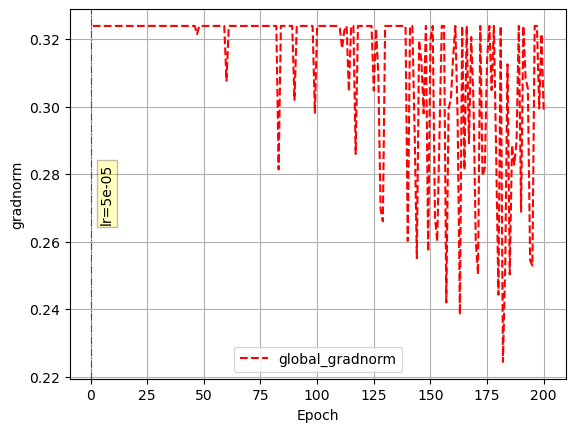



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.2590961933135986


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
58/58 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0011 - NMSE: 0.0102 - covmat_fro_loss: 0.0013 - global_gradnorm: 0.2591 - tot_time: 0h 1m 49.8s

Epoch 1: val_NMSE improved from inf to 0.00960, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_02

Epoch 12/1000
58/58 [==============================] - ETA: 0s - loss: 0.0058 - mse: 8.8781e-04 - NMSE: 0.0080 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.2591 - tot_time: 0h 5m 0.8s

Epoch 12: val_NMSE did not improve from 0.00874
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 17s 301ms/step - loss: 0.0058 - mse: 8.8781e-04 - NMSE: 0.0080 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.2591 - val_loss: 0.0068 - val_mse: 0.0011 - val_NMSE: 0.0095 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
58/58 [==============================] - ETA: 0s - loss: 0.0056 - mse: 8.5195e-04 - NMSE: 0.0077 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.2591 - tot_time: 0h 5m 18.1s

Epoch 13: val_NMSE did not improve from 0.00874
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/che

58/58 [==============================] - ETA: 0s - loss: 0.0054 - mse: 8.1113e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - tot_time: 0h 8m 30.4s

Epoch 24: val_NMSE did not improve from 0.00870
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 18s 306ms/step - loss: 0.0054 - mse: 8.1113e-04 - NMSE: 0.0073 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - val_loss: 0.0065 - val_mse: 0.0010 - val_NMSE: 0.0090 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
58/58 [==============================] - ETA: 0s - loss: 0.0054 - mse: 8.0358e-04 - NMSE: 0.0072 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - tot_time: 0h 8m 48.0s

Epoch 25: val_NMSE did not improve from 0.00870
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/Loss

58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 7.6067e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - tot_time: 0h 11m 59.6s

Epoch 36: val_NMSE did not improve from 0.00845
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 18s 304ms/step - loss: 0.0051 - mse: 7.6067e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - val_loss: 0.0067 - val_mse: 0.0010 - val_NMSE: 0.0093 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 7.6026e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - tot_time: 0h 12m 16.9s

Epoch 37: val_NMSE did not improve from 0.00845
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/Lo

58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.2700e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - tot_time: 0h 15m 28.7s

Epoch 48: val_NMSE did not improve from 0.00844
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 17s 300ms/step - loss: 0.0049 - mse: 7.2700e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - val_loss: 0.0063 - val_mse: 9.6517e-04 - val_NMSE: 0.0087 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 7.5763e-04 - NMSE: 0.0068 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - tot_time: 0h 15m 46.2s

Epoch 49: val_NMSE did not improve from 0.00844
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoint

58/58 [==============================] - ETA: 0s - loss: 0.0049 - mse: 7.1487e-04 - NMSE: 0.0064 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - tot_time: 0h 18m 58.3s

Epoch 60: val_NMSE did not improve from 0.00837
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 17s 295ms/step - loss: 0.0049 - mse: 7.1487e-04 - NMSE: 0.0064 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - val_loss: 0.0062 - val_mse: 9.4310e-04 - val_NMSE: 0.0085 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
58/58 [==============================] - ETA: 0s - loss: 0.0048 - mse: 7.1332e-04 - NMSE: 0.0064 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - tot_time: 0h 19m 15.5s

Epoch 61: val_NMSE did not improve from 0.00837
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoint

Epoch 72/1000
58/58 [==============================] - ETA: 0s - loss: 0.0047 - mse: 6.9425e-04 - NMSE: 0.0062 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - tot_time: 0h 22m 26.3s

Epoch 72: val_NMSE did not improve from 0.00815
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 17s 293ms/step - loss: 0.0047 - mse: 6.9425e-04 - NMSE: 0.0062 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - val_loss: 0.0061 - val_mse: 9.2110e-04 - val_NMSE: 0.0083 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 73/1000
58/58 [==============================] - ETA: 0s - loss: 0.0046 - mse: 6.7734e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - tot_time: 0h 22m 43.3s

Epoch 73: val_NMSE did not improve from 0.00815
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 17s 293ms/step - loss: 0.0046 - mse: 6.7040e-04 - NMSE: 0.0060 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.2591 - val_loss: 0.0062 - val_mse: 9.4473e-04 - val_NMSE: 0.0085 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 85/1000
58/58 [==============================] - ETA: 0s - loss: 0.0045 - mse: 6.6010e-04 - NMSE: 0.0059 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2591 - tot_time: 0h 26m 10.0s

Epoch 85: val_NMSE did not improve from 0.00815
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 17s 300ms/step - loss: 0.0045 - mse: 6.6010e-04 - NMSE: 0.0059 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.2591 - val_loss: 0.0065 - val_mse:

<Figure size 640x480 with 0 Axes>

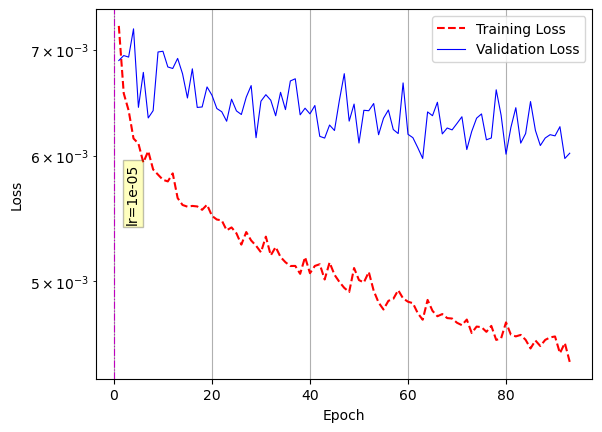

<Figure size 640x480 with 0 Axes>

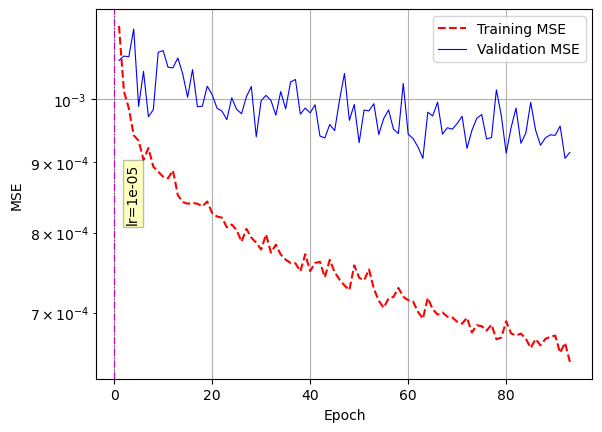

<Figure size 640x480 with 0 Axes>

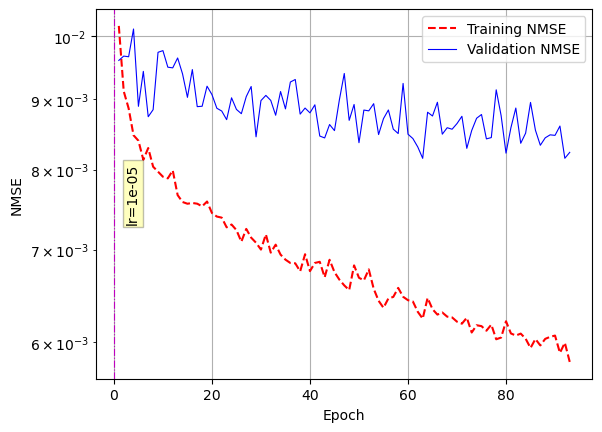

<Figure size 640x480 with 0 Axes>

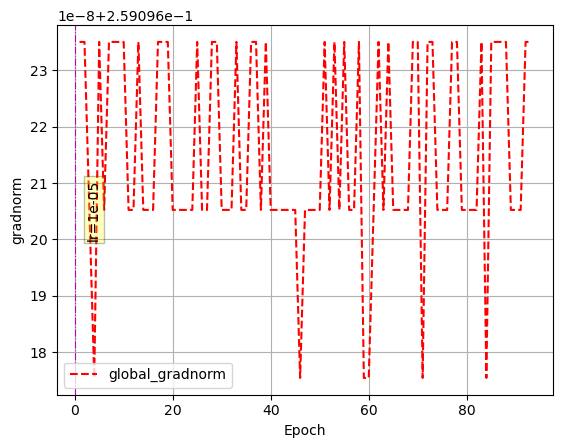



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.20727698802948


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
49/49 [==============================] - ETA: 0s - loss: 0.0101 - mse: 0.0022 - NMSE: 0.0196 - covmat_fro_loss: 0.0019 - global_gradnorm: 0.2073 - tot_time: 0h 3m 17.0s

Epoch 1: val_NMSE improved from inf to 0.02289, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/

Epoch 12/1000
49/49 [==============================] - ETA: 0s - loss: 0.0086 - mse: 0.0018 - NMSE: 0.0164 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.2073 - tot_time: 0h 7m 47.1s

Epoch 12: val_NMSE did not improve from 0.02137
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 24s 498ms/step - loss: 0.0086 - mse: 0.0018 - NMSE: 0.0164 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.2073 - val_loss: 0.0110 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
49/49 [==============================] - ETA: 0s - loss: 0.0085 - mse: 0.0018 - NMSE: 0.0163 - covmat_fro_loss: 0.0018 - global_gradnorm: 0.2073 - tot_time: 0h 8m 11.5s

Epoch 13: val_NMSE did not improve from 0.02137
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/Lo

Epoch 24/1000
49/49 [==============================] - ETA: 0s - loss: 0.0082 - mse: 0.0017 - NMSE: 0.0154 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - tot_time: 0h 12m 39.6s

Epoch 24: val_NMSE did not improve from 0.02059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 24s 491ms/step - loss: 0.0082 - mse: 0.0017 - NMSE: 0.0154 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - val_loss: 0.0108 - val_mse: 0.0023 - val_NMSE: 0.0210 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
49/49 [==============================] - ETA: 0s - loss: 0.0082 - mse: 0.0017 - NMSE: 0.0154 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - tot_time: 0h 13m 3.8s

Epoch 25: val_NMSE did not improve from 0.02059
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/L

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 24s 498ms/step - loss: 0.0080 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - val_loss: 0.0105 - val_mse: 0.0023 - val_NMSE: 0.0205 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 37/1000
49/49 [==============================] - ETA: 0s - loss: 0.0079 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - tot_time: 0h 17m 57.8s

Epoch 37: val_NMSE did not improve from 0.02050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 24s 499ms/step - loss: 0.0079 - mse: 0.0016 - NMSE: 0.0148 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - val_loss: 0.0107 - val_mse: 0.0023 - val_NM

Epoch 49/1000
49/49 [==============================] - ETA: 0s - loss: 0.0077 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - tot_time: 0h 22m 46.6s

Epoch 49: val_NMSE did not improve from 0.02050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 24s 488ms/step - loss: 0.0077 - mse: 0.0016 - NMSE: 0.0143 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - val_loss: 0.0108 - val_mse: 0.0023 - val_NMSE: 0.0210 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 50/1000
49/49 [==============================] - ETA: 0s - loss: 0.0077 - mse: 0.0016 - NMSE: 0.0144 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - tot_time: 0h 23m 10.6s

Epoch 50: val_NMSE did not improve from 0.02050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/

Epoch 61/1000
49/49 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - tot_time: 0h 27m 34.7s

Epoch 61: val_NMSE did not improve from 0.02029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 24s 486ms/step - loss: 0.0075 - mse: 0.0016 - NMSE: 0.0140 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - val_loss: 0.0105 - val_mse: 0.0023 - val_NMSE: 0.0204 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 62/1000
49/49 [==============================] - ETA: 0s - loss: 0.0076 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - tot_time: 0h 27m 58.8s

Epoch 62: val_NMSE did not improve from 0.02029
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/

Epoch 74/1000
49/49 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - tot_time: 0h 32m 48.3s

Epoch 74: val_NMSE improved from 0.02029 to 0.02022, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 24s 499ms/step - loss: 0.0075 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - val_loss: 0.0104 - val_mse: 0.0022 - val_NMSE: 0.0202 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 75/1000
49/49 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - tot_time: 0h 33m 12.8s

Epoch 75: val_NMSE did not impro

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 24s 489ms/step - loss: 0.0074 - mse: 0.0015 - NMSE: 0.0137 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - val_loss: 0.0107 - val_mse: 0.0023 - val_NMSE: 0.0209 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 87/1000
49/49 [==============================] - ETA: 0s - loss: 0.0073 - mse: 0.0015 - NMSE: 0.0136 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - tot_time: 0h 38m 4.2s

Epoch 87: val_NMSE did not improve from 0.02022
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 24s 498ms/step - loss: 0.0073 - mse: 0.0015 - NMSE: 0.0136 - covmat_fro_loss: 0.0017 - global_gradnorm: 0.2073 - val_loss: 0.0106 - val_mse: 0.0023 - val_NMS

Epoch 99/1000
49/49 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2073 - tot_time: 0h 42m 54.1s

Epoch 99: val_NMSE did not improve from 0.02022
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 25s 503ms/step - loss: 0.0072 - mse: 0.0015 - NMSE: 0.0134 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2073 - val_loss: 0.0107 - val_mse: 0.0023 - val_NMSE: 0.0208 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 100/1000
49/49 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0015 - NMSE: 0.0133 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2073 - tot_time: 0h 43m 18.1s

Epoch 100: val_NMSE did not improve from 0.02022
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoint

Epoch 112/1000
49/49 [==============================] - ETA: 0s - loss: 0.0072 - mse: 0.0015 - NMSE: 0.0133 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2073 - tot_time: 0h 48m 9.9s

Epoch 112: val_NMSE did not improve from 0.02022
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 25s 506ms/step - loss: 0.0072 - mse: 0.0015 - NMSE: 0.0133 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2073 - val_loss: 0.0106 - val_mse: 0.0023 - val_NMSE: 0.0207 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 113/1000
49/49 [==============================] - ETA: 0s - loss: 0.0071 - mse: 0.0015 - NMSE: 0.0132 - covmat_fro_loss: 0.0016 - global_gradnorm: 0.2073 - tot_time: 0h 48m 34.3s

Epoch 113: val_NMSE did not improve from 0.02022
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoin

Epoch 124: early stopping


<Figure size 640x480 with 0 Axes>

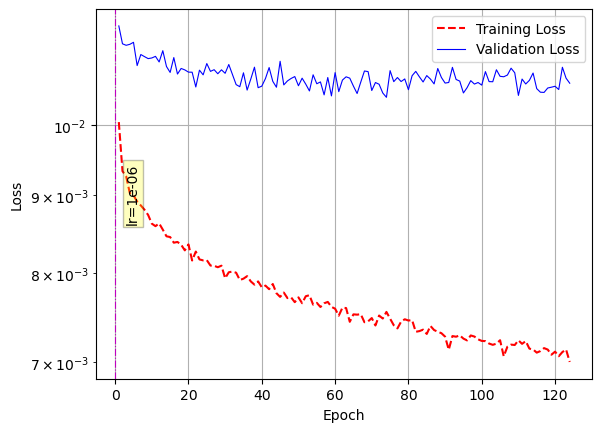

<Figure size 640x480 with 0 Axes>

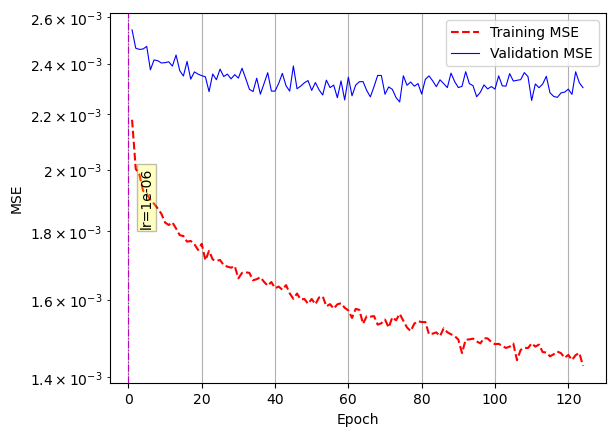

<Figure size 640x480 with 0 Axes>

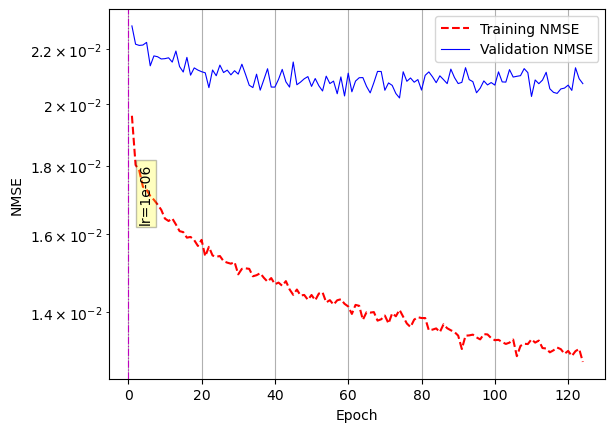

<Figure size 640x480 with 0 Axes>

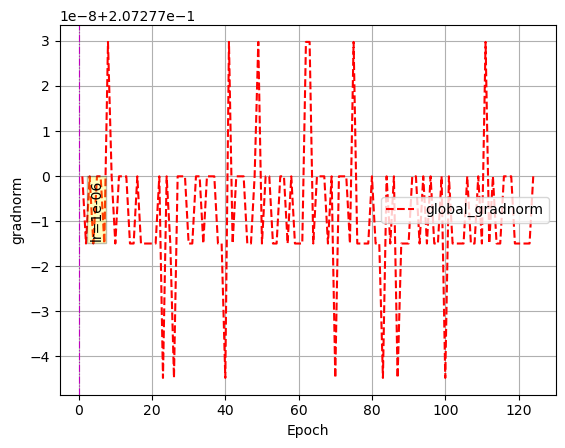



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 70 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.16582162380218507


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-07 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
42/42 [==============================] - ETA: 0s - loss: 0.0161 - mse: 0.0050 - NMSE: 0.0447 - covmat_fro_loss: 0.0025 - global_gradnorm: 0.1658 - tot_time: 0h 4m 22.0s

Epoch 1: val_NMSE improved from inf to 0.04807, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/checkpoint-70_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 11/1000
42/42 [==============================] - ETA: 0s - loss: 0.0142 - mse: 0.0043 - NMSE: 0.0385 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.1658 - tot_time: 0h 8m 56.1s

Epoch 11: val_NMSE improved from 0.04698 to 0.04630, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/checkpoint-70_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 28s 672ms/step - loss: 0.0142 - mse: 0.0043 - NMSE: 0.0385 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.1658 - val_loss: 0.0168 - val_mse: 0.0051 - val_NMSE: 0.0463 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
42/42 [==============================] - ETA: 0s - loss: 0.0141 - mse: 0.0042 - NMSE: 0.0381 - covmat_fro_loss: 0.0024 - global_gradnorm: 0.1658 - tot_time: 0h 9m 24.0s

Epoch 12: val_NMSE did not improve

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 28s 654ms/step - loss: 0.0136 - mse: 0.0040 - NMSE: 0.0364 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - val_loss: 0.0169 - val_mse: 0.0052 - val_NMSE: 0.0465 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
42/42 [==============================] - ETA: 0s - loss: 0.0136 - mse: 0.0041 - NMSE: 0.0365 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - tot_time: 0h 14m 50.8s

Epoch 24: val_NMSE improved from 0.04630 to 0.04625, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/checkpoint-70_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 28s 668ms/step - loss: 0.0136

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 27s 648ms/step - loss: 0.0129 - mse: 0.0038 - NMSE: 0.0345 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - val_loss: 0.0167 - val_mse: 0.0051 - val_NMSE: 0.0460 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
42/42 [==============================] - ETA: 0s - loss: 0.0131 - mse: 0.0039 - NMSE: 0.0350 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - tot_time: 0h 20m 19.5s

Epoch 36: val_NMSE did not improve from 0.04576
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 27s 647ms/step - loss: 0.0131 - mse: 0.0039 - NMSE: 0.0350 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - val_loss: 0.0168 - val_mse: 0.0051 - val_NM

Epoch 48/1000
42/42 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0038 - NMSE: 0.0344 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - tot_time: 0h 25m 46.8s

Epoch 48: val_NMSE did not improve from 0.04550
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 27s 643ms/step - loss: 0.0129 - mse: 0.0038 - NMSE: 0.0344 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - val_loss: 0.0168 - val_mse: 0.0051 - val_NMSE: 0.0463 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 49/1000
42/42 [==============================] - ETA: 0s - loss: 0.0128 - mse: 0.0038 - NMSE: 0.0341 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - tot_time: 0h 26m 14.4s

Epoch 49: val_NMSE did not improve from 0.04550
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/

42/42 [==============================] - ETA: 0s - loss: 0.0125 - mse: 0.0037 - NMSE: 0.0332 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - tot_time: 0h 31m 22.0s

Epoch 60: val_NMSE did not improve from 0.04546
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 28s 663ms/step - loss: 0.0125 - mse: 0.0037 - NMSE: 0.0332 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - val_loss: 0.0166 - val_mse: 0.0051 - val_NMSE: 0.0455 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 61/1000
42/42 [==============================] - ETA: 0s - loss: 0.0124 - mse: 0.0036 - NMSE: 0.0326 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - tot_time: 0h 31m 49.8s

Epoch 61: val_NMSE did not improve from 0.04546
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesC

Epoch 72/1000
42/42 [==============================] - ETA: 0s - loss: 0.0122 - mse: 0.0036 - NMSE: 0.0322 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - tot_time: 0h 36m 50.8s

Epoch 72: val_NMSE did not improve from 0.04515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 28s 658ms/step - loss: 0.0122 - mse: 0.0036 - NMSE: 0.0322 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - val_loss: 0.0167 - val_mse: 0.0051 - val_NMSE: 0.0457 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 73/1000
42/42 [==============================] - ETA: 0s - loss: 0.0122 - mse: 0.0036 - NMSE: 0.0322 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - tot_time: 0h 37m 18.2s

Epoch 73: val_NMSE did not improve from 0.04515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 27s 640ms/step - loss: 0.0120 - mse: 0.0035 - NMSE: 0.0314 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1658 - val_loss: 0.0167 - val_mse: 0.0051 - val_NMSE: 0.0459 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 85/1000
42/42 [==============================] - ETA: 0s - loss: 0.0120 - mse: 0.0035 - NMSE: 0.0315 - covmat_fro_loss: 0.0023 - global_gradnorm: 0.1658 - tot_time: 0h 42m 44.0s

Epoch 85: val_NMSE did not improve from 0.04499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 27s 648ms/step - loss: 0.0120 - mse: 0.0035 - NMSE: 0.0315 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1658 - val_loss: 0.0165 - val_mse: 0.0050 - val_NM

Epoch 97/1000
42/42 [==============================] - ETA: 0s - loss: 0.0118 - mse: 0.0034 - NMSE: 0.0308 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1658 - tot_time: 0h 48m 13.2s

Epoch 97: val_NMSE did not improve from 0.04499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 28s 668ms/step - loss: 0.0118 - mse: 0.0034 - NMSE: 0.0308 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1658 - val_loss: 0.0167 - val_mse: 0.0051 - val_NMSE: 0.0458 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 98/1000
42/42 [==============================] - ETA: 0s - loss: 0.0118 - mse: 0.0034 - NMSE: 0.0310 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1658 - tot_time: 0h 48m 40.5s

Epoch 98: val_NMSE did not improve from 0.04499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/

Epoch 110/1000
42/42 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0034 - NMSE: 0.0303 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1658 - tot_time: 0h 54m 5.2s

Epoch 110: val_NMSE did not improve from 0.04499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 27s 642ms/step - loss: 0.0116 - mse: 0.0034 - NMSE: 0.0303 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1658 - val_loss: 0.0166 - val_mse: 0.0050 - val_NMSE: 0.0454 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 111/1000
42/42 [==============================] - ETA: 0s - loss: 0.0116 - mse: 0.0034 - NMSE: 0.0303 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1658 - tot_time: 0h 54m 31.8s

Epoch 111: val_NMSE did not improve from 0.04499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoin

Epoch 123/1000
42/42 [==============================] - ETA: 0s - loss: 0.0114 - mse: 0.0033 - NMSE: 0.0296 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1658 - tot_time: 0h 59m 52.8s

Epoch 123: val_NMSE did not improve from 0.04499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoints/LossHistoriesCheckpoint-70_outsteps
42/42 [==============================] - 27s 633ms/step - loss: 0.0114 - mse: 0.0033 - NMSE: 0.0296 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1658 - val_loss: 0.0165 - val_mse: 0.0050 - val_NMSE: 0.0452 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 124/1000
42/42 [==============================] - ETA: 0s - loss: 0.0113 - mse: 0.0033 - NMSE: 0.0294 - covmat_fro_loss: 0.0022 - global_gradnorm: 0.1658 - tot_time: 1h 0m 19.5s

Epoch 124: val_NMSE did not improve from 0.04499
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_027/checkpoin

<Figure size 640x480 with 0 Axes>

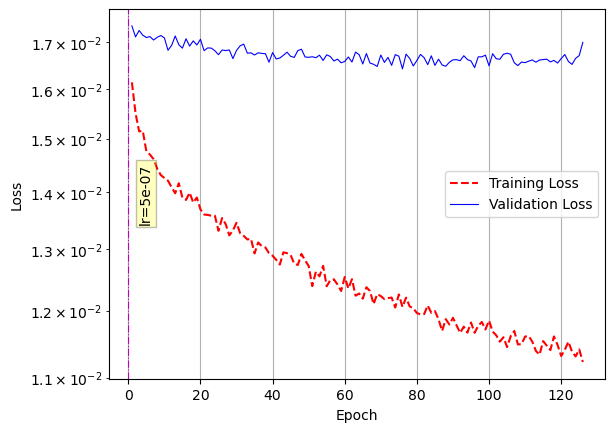

<Figure size 640x480 with 0 Axes>

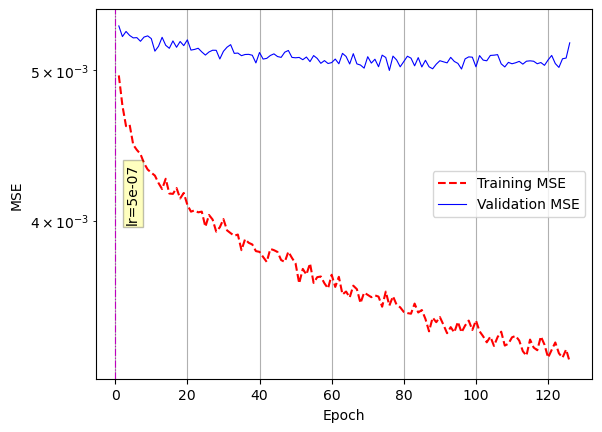

<Figure size 640x480 with 0 Axes>

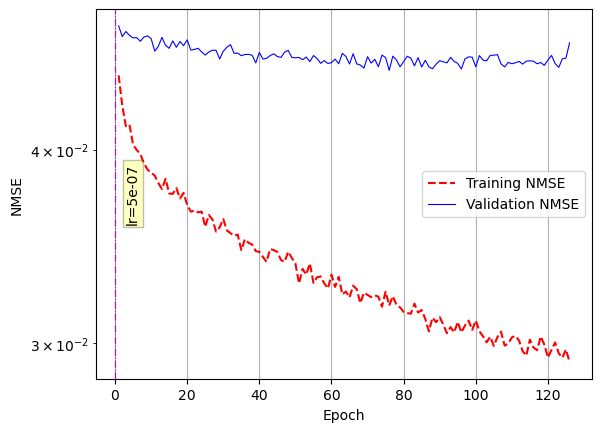

<Figure size 640x480 with 0 Axes>

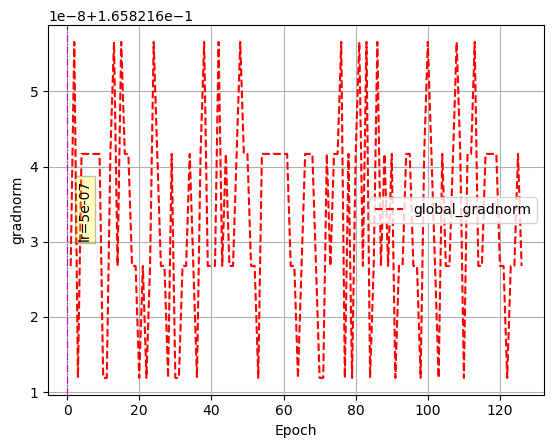

<Figure size 640x480 with 0 Axes>

In [21]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    grad_norm_decay = 0.8
    idxs_to_ignore = 0

    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    # global_clipnorm = 0.25 * np.round(4*global_clipnorm)
    global_clipnorm = grad_norm_decay * global_clipnorm

In [22]:
a = 123e-5
a

0.00123

In [23]:
s = '{:E}'.format(a)
s

'1.230000E-03'

In [24]:
idx = s.find('E')
num = float(s[0:idx])
10**float(s[idx+1:])

0.001

In [25]:
### Training the combined AE-RNN


# 